In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [13]:
from google.colab import files
uploaded = files.upload()


Saving restaurant.csv to restaurant (1).csv


In [12]:
restaurant = pd.read_csv('restaurant.csv')
provinsi = pd.read_csv('provinsi.csv')
makanan_khas = pd.read_csv('makanan_khas.csv')

In [11]:
restaurant_provinsi = pd.merge(restaurant, provinsi, on='id_provinsi')
data_gabungan = pd.merge(restaurant_provinsi, makanan_khas, on='id_makanan')
data_gabungan = data_gabungan[['id_restaurant', 'nama_tempat', 'alamat', 'id_provinsi', 'nama_provinsi', 'id_makanan', 'makanan_khas', 'deskripsi', 'long', 'lat']]

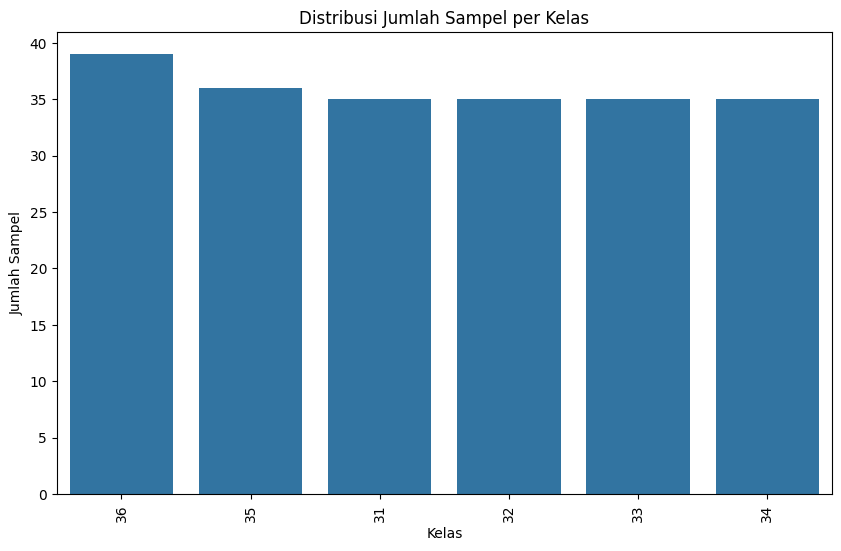

In [15]:
class_column = 'id_provinsi'
plt.figure(figsize=(10, 6))
sns.countplot(data=data_gabungan, x=class_column, order=data_gabungan[class_column].value_counts().index)
plt.title('Distribusi Jumlah Sampel per Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Sampel')
plt.xticks(rotation=90)
plt.show()

In [16]:
samples_per_class = data_gabungan[class_column].value_counts()
print(f"Jumlah sampel per kelas:\n{samples_per_class}")

Jumlah sampel per kelas:
id_provinsi
36    39
35    36
31    35
32    35
33    35
34    35
Name: count, dtype: int64


In [17]:
samples_per_class = data_gabungan[class_column].value_counts()
print(f"Statistik Jumlah Sampel per Kelas:\n{samples_per_class.describe()}")
print(f"Jumlah sampel minimal dalam satu kelas: {samples_per_class.min()}")
print(f"Jumlah sampel maksimal dalam satu kelas: {samples_per_class.max()}")

Statistik Jumlah Sampel per Kelas:
count     6.000000
mean     35.833333
std       1.602082
min      35.000000
25%      35.000000
50%      35.000000
75%      35.750000
max      39.000000
Name: count, dtype: float64
Jumlah sampel minimal dalam satu kelas: 35
Jumlah sampel maksimal dalam satu kelas: 39


In [18]:
data_gabungan.isnull().sum().sort_values(ascending = False)

id_restaurant    0
nama_tempat      0
alamat           0
id_provinsi      0
nama_provinsi    0
id_makanan       0
makanan_khas     0
deskripsi        0
long             0
lat              0
dtype: int64

In [19]:
data_gabungan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id_restaurant  215 non-null    int64  
 1   nama_tempat    215 non-null    object 
 2   alamat         215 non-null    object 
 3   id_provinsi    215 non-null    int64  
 4   nama_provinsi  215 non-null    object 
 5   id_makanan     215 non-null    int64  
 6   makanan_khas   215 non-null    object 
 7   deskripsi      215 non-null    object 
 8   long           215 non-null    float64
 9   lat            215 non-null    float64
dtypes: float64(2), int64(3), object(5)
memory usage: 16.9+ KB


In [20]:
data_gabungan.duplicated().sum()

0

In [21]:
coords = restaurant[['long', 'lat']].values

In [22]:
# Define KNN Model
knn = NearestNeighbors(n_neighbors= 5)
knn.fit(coords)

def find_nearest_knn(lat, lon):
    distances, indices = knn.kneighbors([[lon, lat]])
    return indices[0], distances[0]

In [23]:
# Save model KNN
dump(knn, 'knn_model.joblib')

# load model KNN
knn_loaded = load('knn_model.joblib')

In [26]:
# TensorFlow Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(64, activation='relu'),
    Dense(2)
])

model.compile(optimizer='adam', loss='mse')

X = coords
y = coords

model.fit(X, y, epochs=100, verbose=0)

def predict_with_tf(lon, lat):
    input_coord = np.array([[lon, lat]])
    pred_coord = model.predict(input_coord)
    return pred_coord

In [27]:
def get_combined_nearest_location(lat, lon):
    indices, distances = find_nearest_knn(lat, lon)
    nearest_candidates = coords[indices]

    refined_coord = predict_with_tf(lon, lat)

    refined_distances = np.sqrt((nearest_candidates[:, 0] - refined_coord[0][0]) ** 2 + (nearest_candidates[:, 1] - refined_coord[0][1]) ** 2)
    nearest_index = np.argmin(refined_distances)

    return restaurant.iloc[indices[nearest_index]]

In [28]:
# Save the TensorFlow model
model.save('tensorflow_model.h5')

# Load the TensorFlow model
from tensorflow.keras.models import load_model
model_loaded = load_model('tensorflow_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
from sklearn.metrics import mean_squared_error

# Evaluasi KNN menggunakan jarak rata-rata dari prediksi ke lokasi asli
def evaluate_knn(knn_model, X_test, y_test):
    distances, indices = knn_model.kneighbors(X_test)
    y_pred = coords[indices[:, 0]]
    mse = mean_squared_error(y_test, y_pred)
    return mse

X_test = np.array([[106.149564, -6.143376]])
y_test = np.array([[106.149564, -6.143376]])
knn_mse = evaluate_knn(knn_loaded, X_test, y_test)
print(f"KNN Mean Squared Error: {knn_mse}")


KNN Mean Squared Error: 0.0


In [40]:
# Evaluasi TensorFlow model
loss = model_loaded.evaluate(X_test, y_test)
print(f"TensorFlow Model Loss: {loss}")


1/1 [==============================] - 0s 30ms/step - loss: 0.1082
TensorFlow Model Loss: 0.10820603370666504


In [41]:
def get_combined_nearest_location(lat, lon):
    indices, distances = find_nearest_knn(lat, lon)
    nearest_candidates = coords[indices]

    refined_coord = predict_with_tf(lon, lat)

    refined_distances = np.sqrt((nearest_candidates[:, 0] - refined_coord[0][0]) ** 2 + (nearest_candidates[:, 1] - refined_coord[0][1]) ** 2)
    nearest_index = np.argmin(refined_distances)

    return restaurant.iloc[indices[nearest_index]]

user_lat = -6.143376
user_lon = 106.149564

nearest_location = get_combined_nearest_location(user_lat, user_lon)
print("Nearest location using combined KNN and TensorFlow:")
print(nearest_location)


1/1 [==============================] - 0s 63ms/step
Nearest location using combined KNN and TensorFlow:
id_restaurant                                                    1
id_reting                                                        1
id_makanan                                                       1
id_provinsi                                                     36
id_kabupaten                                                  3673
nama_tempat                         Sate Bandeng Ibu Amenah Serang
alamat           Jl. Sayabulu km 1, Lingk No.11, RT.2/RW.1, Dal...
long                                                    106.149564
lat                                                      -6.143376
Name: 0, dtype: object


In [42]:
import tensorflow as tf

# Load TensorFlow model
model = tf.keras.models.load_model('tensorflow_model.h5')

# Convert model ke format TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TensorFlow Lite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)